In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml

%load_ext jupyter_black

## Data Generation

In [2]:
def gen_XY(n=1000, seed=0):
    np.random.seed(seed)
    X, Y0 = datasets.make_friedman1(n_samples=n, noise=1, random_state=seed)
    Y1 = Y0 + np.log(Y0 + 1)
    p = X.shape[1]

    # p_discrete = 5
    # p_continuous = p - p_discrete
    # Xc = np.random.normal(0,1,size=(n,p_continuous))
    # Xd = np.random.binomial(1,0.5,size=(n,p_discrete))
    # X = np.hstack((Xc,Xd))
    return pd.DataFrame(X, columns=["X%d" % (i) for i in range(p)]), pd.DataFrame(
        np.hstack((Y0.reshape(-1, 1), Y1.reshape(-1, 1))), columns=["Y0", "Y1"]
    )


def gen_S(X, seed=0):
    np.random.seed(seed)
    a = 0.25 - 2 * ((X["X0"] > 0.5) * (X["X0"] < 1) * (X["X1"] > 0.5) * (X["X1"] < 1))
    S = np.random.binomial(1, sp.expit(a))
    return pd.DataFrame(S, columns=["S"])


def gen_T(X, S, seed=0):
    np.random.seed(seed)
    pi_exp = 0.5
    pi_obs = sp.expit(X["X0"])
    pi = S["S"] * pi_exp + (1 - S["S"]) * pi_obs
    T = np.random.binomial(1, pi)
    return pd.DataFrame(T, columns=["T"]), pi


def get_data(n=1000, seed=10240):
    X, Y = gen_XY(n=n, seed=seed)
    S = gen_S(X, seed=seed)
    T, pi = gen_T(X, S, seed=seed)
    X["Yobs"] = T["T"] * Y["Y1"] + (1 - T["T"]) * Y["Y0"]
    return pd.concat([X, S, T], axis=1), Y

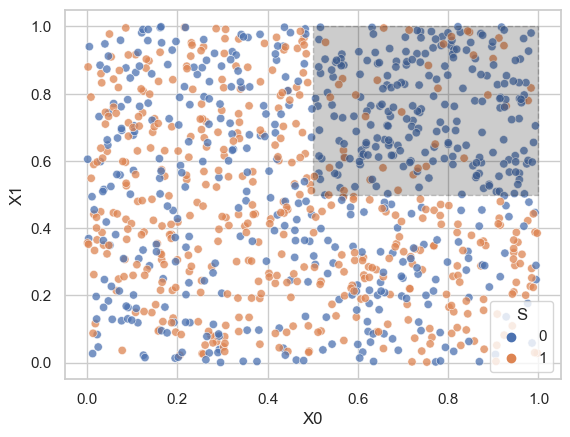

In [3]:
df, Y = get_data()

sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75)
ax.add_patch(
    Rectangle((0.5, 0.5), 0.5, 0.5, color="black", ls="--", alpha=0.2, fill=True)
)

# Characterize Under-represented Population
1. Estimate CATE $\tau(x)$ and ATE $\tau$ for experimental sample
2. Estimate proclivity-score $P(S=1 \mid X=x)$ using both experimental and observational sample
3. Calculate heterogeneity-score $h(x) = (\tau(x) - \tau)^2$, and representation-score $r(x) = log P(S=1 \mid X=x) - log P(S=0 \mid X=x)$
4. Combine them using predefined weights $\alpha$ to calculate objective value $z(x) = \alpha_0 r(x) - \alpha_1 h(x)$
5. Fit regularized decision-tree to tasselate the space into (non-overlapping) hyper-boxes -- $z \sim x$
    1. For regulatization, one can use minimum number of nodes in a leaf and/or maximum tree depth
6. Find the hyper-box(es) with the minimum average objective value

### Estimate TE

In [4]:
use_true_cate = True
df_exp = df.loc[(df["S"] == 1)]

In [5]:
if use_true_cate:
    tau = Y.loc[(df["S"] == 1)]["Y1"] - Y.loc[(df["S"] == 1)]["Y0"]
else:
    y1_est = en.GradientBoostingRegressor(max_depth=3).fit(
        df_exp.loc[(df_exp["T"] == 1)].drop(columns=["Yobs", "T", "S"]),
        df_exp.loc[(df_exp["T"] == 1), "Yobs"],
    )

    y0_est = en.GradientBoostingRegressor(max_depth=3).fit(
        df_exp.loc[(df_exp["T"] == 0)].drop(columns=["Yobs", "T", "S"]),
        df_exp.loc[(df_exp["T"] == 0), "Yobs"],
    )
    tau = y1_est.predict(df_exp.drop(columns=["Yobs", "T", "S"])) - y0_est.predict(
        df_exp.drop(columns=["Yobs", "T", "S"])
    )

h_score = en.GradientBoostingRegressor(max_depth=2).fit(
    df_exp.drop(columns=["Yobs", "T", "S"]), tau
)

### Estimate Proclivity Score

In [6]:
r_score = en.GradientBoostingClassifier(max_depth=2).fit(
    df.drop(columns=["Yobs", "T", "S"]), df["S"]
)

### Estimate representiveness-score and heterogeneity-score

In [7]:
r = r_score.predict_log_proba(df_exp.drop(columns=["Yobs", "T", "S"]))
result = pd.DataFrame(r[:, 1] - r[:, 0], columns=["r"], index=df_exp.index)

h = h_score.predict(df_exp.drop(columns=["Yobs", "T", "S"]))
h = (h - np.mean(h)) ** 2
result["h"] = h

# Objective Score
alpha = [5, 1]
result["obj"] = alpha[0] * result["r"] - alpha[1] * result["h"]

### Tessellate

In [8]:
m = tree.DecisionTreeRegressor(min_samples_leaf=50).fit(
    df_exp.drop(columns=["Yobs", "T", "S"]), result["obj"]
)

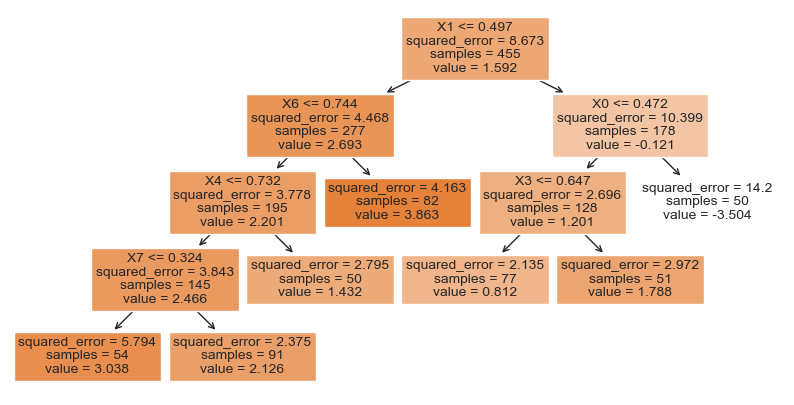

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_tree = tree.plot_tree(
    m, filled=True, ax=ax, feature_names=df_exp.drop(columns=["Yobs", "T", "S"]).columns
)

In [10]:
m.tree_.value

array([[[ 1.59207741]],

       [[ 2.69268247]],

       [[ 2.20059165]],

       [[ 2.46555199]],

       [[ 3.03810521]],

       [[ 2.12579513]],

       [[ 1.43220666]],

       [[ 3.86289844]],

       [[-0.12066192]],

       [[ 1.20098169]],

       [[ 0.81240206]],

       [[ 1.78766075]],

       [[-3.50406958]]])